# Softmax 练习

*补充并完成本练习。*

本练习类似于SVM练习，你要完成的事情包括:

- 为Softmax分类器实现完全矢量化的**损失函数**
- 实现其**解析梯度（analytic gradient）**的完全矢量化表达式
- 用数值梯度**检查你的代码**
- 使用验证集**调整学习率和正则化强度**
- 使用**SGD优化**损失函数
- **可视化**最终学习的权重


In [1]:
import random
import numpy as np
from daseCV.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'daseCV/datasets/cifar-10-batches-py'
    
    # Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
    try:
       del X_train, y_train
       del X_test, y_test
       print('Clear previously loaded data.')
    except:
       pass

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image 标准化数据
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns 增加常数1的一列
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax 分类器

请在**daseCV/classifiers/softmax.py**中完成本节的代码。

In [3]:
# 首先使用嵌套循环实现简单的softmax损失函数。
# 打开文件 daseCV/classifiers/softmax.py 并补充完成
# softmax_loss_naive 函数.

from daseCV.classifiers.softmax import softmax_loss_naive
import time

# 生成一个随机的softmax权重矩阵，并使用它来计算损失。
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.323706
sanity check: 2.302585


**问题 1**


为什么我们期望损失接近-log（0.1）？简要说明。

$\color{blue}{\textit 答:}$ *权重矩阵w在随机初始化后与X做乘法使得各个样本在分类得到的每个类计算的得分都是相同的，接近于0，经过softmax之后计算得到的概率也是一样的，又因为本例中的label的数量为10，那么每个label下的得分接近于1/10，所以每个类的概率是0.1,经过交叉熵得到的loss就是-log（0.1）* 



In [4]:
# 完成softmax_loss_naive，并实现使用嵌套循环的梯度的版本(naive)。
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# 就像SVM那样，请使用数值梯度检查作为调试工具。
# 数值梯度应接近分析梯度。
from daseCV.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# 与SVM情况类似，使用正则化进行另一个梯度检查
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: 2.595650 analytic: 2.595650, relative error: 1.603091e-08
numerical: -0.526392 analytic: -0.526392, relative error: 8.976654e-08
numerical: 0.989391 analytic: 0.989391, relative error: 9.797623e-08
numerical: 0.266568 analytic: 0.266568, relative error: 2.262529e-07
numerical: -0.648064 analytic: -0.648064, relative error: 2.509118e-08
numerical: -0.512166 analytic: -0.512166, relative error: 1.111595e-07
numerical: -1.542244 analytic: -1.542243, relative error: 1.457739e-08
numerical: 0.671180 analytic: 0.671180, relative error: 5.247251e-08
numerical: -1.486132 analytic: -1.486132, relative error: 4.172254e-09
numerical: -4.911044 analytic: -4.911044, relative error: 1.040346e-08
numerical: -1.334857 analytic: -1.334857, relative error: 1.232085e-08
numerical: -1.132719 analytic: -1.132719, relative error: 5.273798e-08
numerical: -1.078888 analytic: -1.078888, relative error: 3.888692e-08
numerical: 0.140603 analytic: 0.140603, relative error: 3.871151e-07
numerical: -2.22

In [5]:
# 现在，我们有了softmax损失函数及其梯度的简单实现，
# 接下来要在 softmax_loss_vectorized 中完成一个向量化版本.
# 这两个版本应计算出相同的结果，但矢量化版本应更快。
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from daseCV.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# 正如前面在SVM练习中所做的一样，我们使用Frobenius范数比较两个版本梯度。
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.323706e+00 computed in 0.230195s
vectorized loss: 2.323706e+00 computed in 0.012197s
Loss difference: 0.000000
Gradient difference: 0.000000


In [13]:
# 使用验证集调整超参数（正则化强度和学习率）。您应该尝试不同的学习率和正则化强度范围; 
# 如果您小心的话，您应该能够在验证集上获得超过0.35的精度。
from daseCV.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None
learning_rates = [1e-7, 3e-7,5e-7]
regularization_strengths = [2.5e4, 3e4,3.5e4,5e4]

################################################################################
# 需要完成的事:                                                                        
# 对验证集设置学习率和正则化强度。
# 这与之前SVM中做的类似；
# 保存训练效果最好的softmax分类器到best_softmax中。
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

iters = 5000

for learn_rate in learning_rates:
    for regularization_strength in regularization_strengths:
        softmax = Softmax()
        softmax.train(X_train, y_train, learning_rate=learn_rate, reg=regularization_strength, num_iters=iters)

        y_train_pred = softmax.predict(X_train)
        accuracy_train = np.mean(y_train == y_train_pred)
        y_val_pred = softmax.predict(X_val)
        accuracy_val = np.mean(y_val == y_val_pred)

        results[(learn_rate, regularization_strength)] = (accuracy_train, accuracy_val)

        if best_val < accuracy_val:
            best_val = accuracy_val
            best_softmax = softmax



pass

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

lr 1.000000e-07 reg 2.500000e+04 train accuracy: 0.329163 val accuracy: 0.347000
lr 1.000000e-07 reg 3.000000e+04 train accuracy: 0.325510 val accuracy: 0.342000
lr 1.000000e-07 reg 3.500000e+04 train accuracy: 0.307714 val accuracy: 0.331000
lr 1.000000e-07 reg 5.000000e+04 train accuracy: 0.306204 val accuracy: 0.326000
lr 3.000000e-07 reg 2.500000e+04 train accuracy: 0.335918 val accuracy: 0.355000
lr 3.000000e-07 reg 3.000000e+04 train accuracy: 0.322388 val accuracy: 0.345000
lr 3.000000e-07 reg 3.500000e+04 train accuracy: 0.320592 val accuracy: 0.328000
lr 3.000000e-07 reg 5.000000e+04 train accuracy: 0.309571 val accuracy: 0.321000
lr 5.000000e-07 reg 2.500000e+04 train accuracy: 0.329837 val accuracy: 0.345000
lr 5.000000e-07 reg 3.000000e+04 train accuracy: 0.318918 val accuracy: 0.329000
lr 5.000000e-07 reg 3.500000e+04 train accuracy: 0.310551 val accuracy: 0.325000
lr 5.000000e-07 reg 5.000000e+04 train accuracy: 0.309551 val accuracy: 0.327000
best validation accuracy ach

In [14]:
# 在测试集上评估
# 在测试集上评估最好的softmax
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.352000


**问题 2** - *对或错*

假设总训练损失定义为所有训练样本中每个数据点损失的总和。可能会有新的数据点添加到训练集中，同时SVM损失保持不变，但是对于Softmax分类器的损失而言，情况并非如此。

$\color{blue}{\textit 你的回答:}$ 

SVM的损失函数的计算为$L_{i} = \sum(\max(0,S_{j}-S_{y_{i}}+1))$,那么当新加入的训练集点，若其分类到非正确类别的分数低于分类到正确的类别的分数且低的值比较大，那么这个训练集点的损失函数值为0，加入这个训练集点对于总的损失值变化为0，所以SVM损失可以保持不变。
但是对于Softmax分类的损失函数计算公式为$L_{i} = -log\frac{\exp{S_i}}{\sum(\exp{S_j})}$当加入一个训练集点，该点的损失值不可能为0，那么总体的损失值必定会带来变化


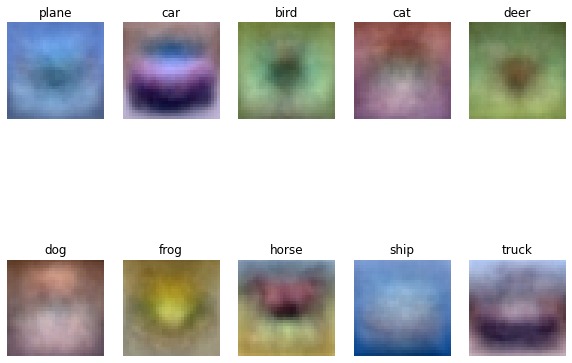

In [15]:
# 可视化每个类别的学习到的权重
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

### Data for leaderboard
这里额外提供了一组未给标签的测试集X，用于leaderborad上的竞赛。

---
提示：该题的目的是鼓励同学们探索能够提升模型性能的方法。

In [16]:
# leaderboard的测试数据
X = np.load("./input/X_3073.npy")
################################################################################
# 需要完成的事情: 
# 找到更合适的softmax
# 提示：如果你不想花时间，你也可以直接使用上面已经训练好的best_softmax。                   
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
softmax_leaderboard = best_softmax
preds = softmax_leaderboard.predict(X)

提醒：运行完下面代码之后，点击下面的submit，然后去leaderboard上查看你的成绩。本模型对应的成绩在phase3的leaderboard中。

In [17]:
import os
#输出格式
def output_file(preds, phase_id=3):
    path=os.getcwd()
    if not os.path.exists(path + '/output/phase_{}'.format(phase_id)):
        os.mkdir(path + '/output/phase_{}'.format(phase_id))
    path=path + '/output/phase_{}/prediction.npy'.format(phase_id)
    np.save(path,preds)
def zip_fun(phase_id=3):
    path=os.getcwd()
    output_path = path + '/output'
    files = os.listdir(output_path)
    for _file in files:
        if _file.find('zip') != -1:
            os.remove(output_path + '/' + _file)
    newpath=path+'/output/phase_{}'.format(phase_id)
    os.chdir(newpath)
    cmd = 'zip ../prediction_phase_{}.zip prediction.npy'.format(phase_id)
    os.system(cmd)
    os.chdir(path)
output_file(preds)
zip_fun()